# Lagged cross-covariance analysis

Resolution: 1-degree, monthly

---

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils

In [4]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("white")

In [5]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [6]:
# Cut datasets to a regular grid and resample to monthly averages within each grid cell
df_sif_monthly = (
    utils.regrid(DS_sif, res=1)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    utils.regrid(DS_xco2, res=1)
    .groupby(["lon", "lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lon", "lat", "time"], how="outer")
df_grid_monthly

,lon,lat,time,sif,xco2
0,-179.5,-85.5,2014-11-01,0.009041,NaN
1,-179.5,-85.5,2014-12-01,-0.119375,NaN
2,-179.5,-85.5,2015-01-01,NaN,NaN
3,-179.5,-85.5,2015-02-01,NaN,NaN
4,-179.5,-85.5,2015-03-01,NaN,NaN
...,...,...,...,...,...
1583238,167.5,-45.5,2020-06-01,NaN,NaN
1583239,167.5,-45.5,2020-07-01,NaN,410.175995
1583240,173.5,-35.5,2020-03-01,NaN,409.604797
1583241,173.5,-35.5,2020-04-01,NaN,NaN


In [6]:
# Check coverage
df_monthly_counts = df_grid_monthly.dropna().groupby(["lon", "lat"]).count()
df_monthly_counts

time  sif  xco2
lon    lat                  
-179.5 67.5     1    1     1
       68.5     9    9     9
       71.5     4    4     4
-178.5 65.5     9    9     9
       66.5    12   12    12
...           ...  ...   ...
 178.5 63.5     9    9     9
       65.5    15   15    15
       66.5    11   11    11
       67.5    14   14    14
       68.5    13   13    13

[15025 rows x 3 columns]

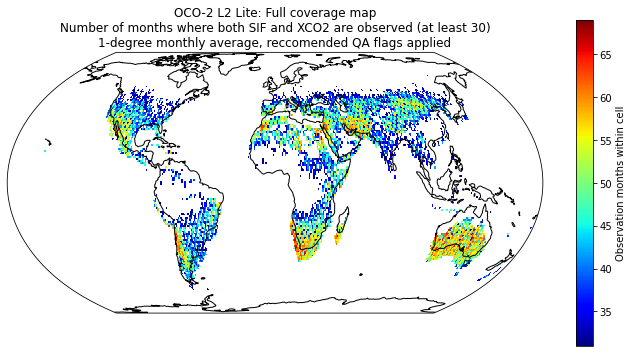

In [25]:
# Coverage map
DS_monthly_counts = df_monthly_counts.to_xarray()
da_counts = xarray.where(DS_monthly_counts.time > 30, DS_monthly_counts.time, np.nan)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(da_counts.T, transform=ccrs.PlateCarree(),
                   cmap=cmap, cbar_kwargs={"label": "Observation months within cell"}, ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Full coverage map\n" 
             "Number of months where both SIF and XCO2 are observed (at least 30)\n"
             "1-degree monthly average, reccomended QA flags applied")

plt.savefig("../plots/1degree_monthly_coverage.png")

In [7]:
# Convert to dataset
DS_grid_monthly = df_grid_monthly.set_index(["lon", "lat", "time"]).to_xarray()
DS_grid_monthly

<xarray.Dataset>
Dimensions:  (lat: 165, lon: 360, time: 71)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -85.5 -84.5 -83.5 -82.5 -81.5 ... 79.5 80.5 81.5 82.5
  * time     (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif      (lon, lat, time) float32 nan nan 0.009041228 ... nan nan nan
    xco2     (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan

In [12]:
# Compute cross covariance for each grid cell
da_xcov_monthly = stats.apply_cross_covariance(DS_grid_monthly.xco2, DS_grid_monthly.sif, lag=2)

da_xcov_monthly

<xarray.DataArray (lon: 360, lat: 165)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -85.5 -84.5 -83.5 -82.5 -81.5 ... 79.5 80.5 81.5 82.5

Text(0.5, 1.0, 'OCO-2 L2 Lite: Cross-covariance of XCO2 and (3 month lagged) SIF\n1-degree monthly average, reccomended QA flags applied')

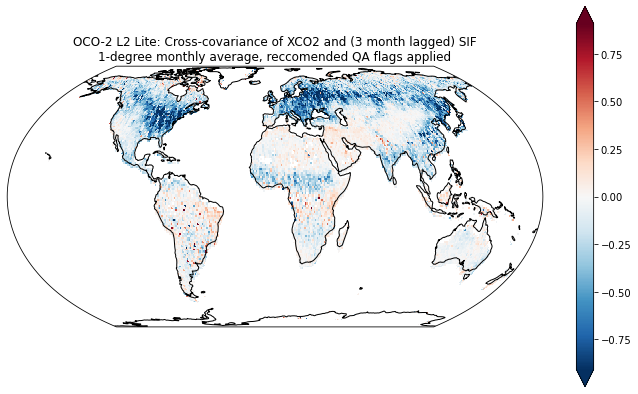

In [13]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(da_xcov_monthly.T, robust=True,
                   transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Cross-covariance of XCO2 and (3 month lagged) SIF\n" 
             "1-degree monthly average, reccomended QA flags applied")

# plt.savefig("../plots/1degree_monthly_xcov.png");